In [1]:
# Import Libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import data
image_ds = '/content/drive/Shareddrives/Capstone/Dataset_final'

print('class_name: ', os.listdir(image_ds))
print('the number of class: ',len(os.listdir(image_ds)))

class_name:  ['battery', 'lamp', 'keyboard', 'mouse', 'smartphone', 'fan', 'cable', 'laptop', 'headphones', 'monitor', 'speaker', 'television']
the number of class:  12


In [3]:
# data splitting we use split-folders libraries from pypi.org to split the data into train, val, and test
!pip install split-folders
import splitfolders

splitfolders.ratio(input = image_ds, 
                   output = '/content/dataset',
                   seed = 42,
                   ratio = (0.9, 0.05, 0.05),
                   group_prefix = None)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 7200 files [01:28, 81.49 files/s] 


In [4]:
# dataset pre-process
train_dir = '/content/dataset/train'
val_dir = '/content/dataset/val'
test_dir = '/content/dataset/test'

class_names = ['battery','cable','fan','headphones','keyboard','lamp','laptop','monitor','mouse','smartphone','speaker','television']

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            batch_size=128,
                                                            image_size=(224, 224),
                                                            labels='inferred',
                                                            label_mode='int',
                                                            class_names=class_names)


val_dataset = tf.keras.utils.image_dataset_from_directory(val_dir,
                                                          batch_size=32,
                                                          image_size=(224, 224),
                                                          labels='inferred',
                                                          label_mode='int',
                                                          class_names=class_names)


test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                           batch_size=32,
                                                           image_size=(224, 224),
                                                           labels='inferred',
                                                           label_mode='int',
                                                           class_names=class_names)

Found 6459 files belonging to 12 classes.
Found 359 files belonging to 12 classes.
Found 360 files belonging to 12 classes.


In [ ]:
# sample data
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
# create image augmentation layer
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])

In [ ]:
# data augmentation sample
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [6]:
# add preprocess_input from base_model
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

In [7]:
# create the base model
base_model = tf.keras.applications.InceptionV3(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')

# freeze the base model layer
base_model.trainable = False

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

In [8]:
# create new custom layer and assemble the model for prediction with custom dataset
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024)(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(12, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [9]:
# compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [10]:
# train the model
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset)

Epoch 1/10
51/51 [==============================] - 52s 499ms/step - loss: 3.4368 - accuracy: 0.5871 - val_loss: 0.7811 - val_accuracy: 0.8217
Epoch 2/10
51/51 [==============================] - 21s 381ms/step - loss: 1.3099 - accuracy: 0.7483 - val_loss: 0.9134 - val_accuracy: 0.8245
Epoch 3/10
51/51 [==============================] - 24s 420ms/step - loss: 1.2648 - accuracy: 0.7569 - val_loss: 0.6477 - val_accuracy: 0.8524
Epoch 4/10
51/51 [==============================] - 22s 390ms/step - loss: 1.1562 - accuracy: 0.7819 - val_loss: 0.7781 - val_accuracy: 0.8245
Epoch 5/10
51/51 [==============================] - 22s 384ms/step - loss: 1.1828 - accuracy: 0.7715 - val_loss: 0.6717 - val_accuracy: 0.8579
Epoch 6/10
51/51 [==============================] - 24s 422ms/step - loss: 1.1063 - accuracy: 0.7956 - val_loss: 0.8935 - val_accuracy: 0.8050
Epoch 7/10
51/51 [==============================] - 23s 385ms/step - loss: 1.0028 - accuracy: 0.8046 - val_loss: 0.7469 - val_accuracy: 0.8301

In [ ]:
# model train monitoring
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [12]:
# evaluate the model
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

12/12 [==============================] - 2s 83ms/step - loss: 0.6609 - accuracy: 0.8639
Test accuracy : 0.8638888597488403


1/1 [==============================] - 0s 34ms/step


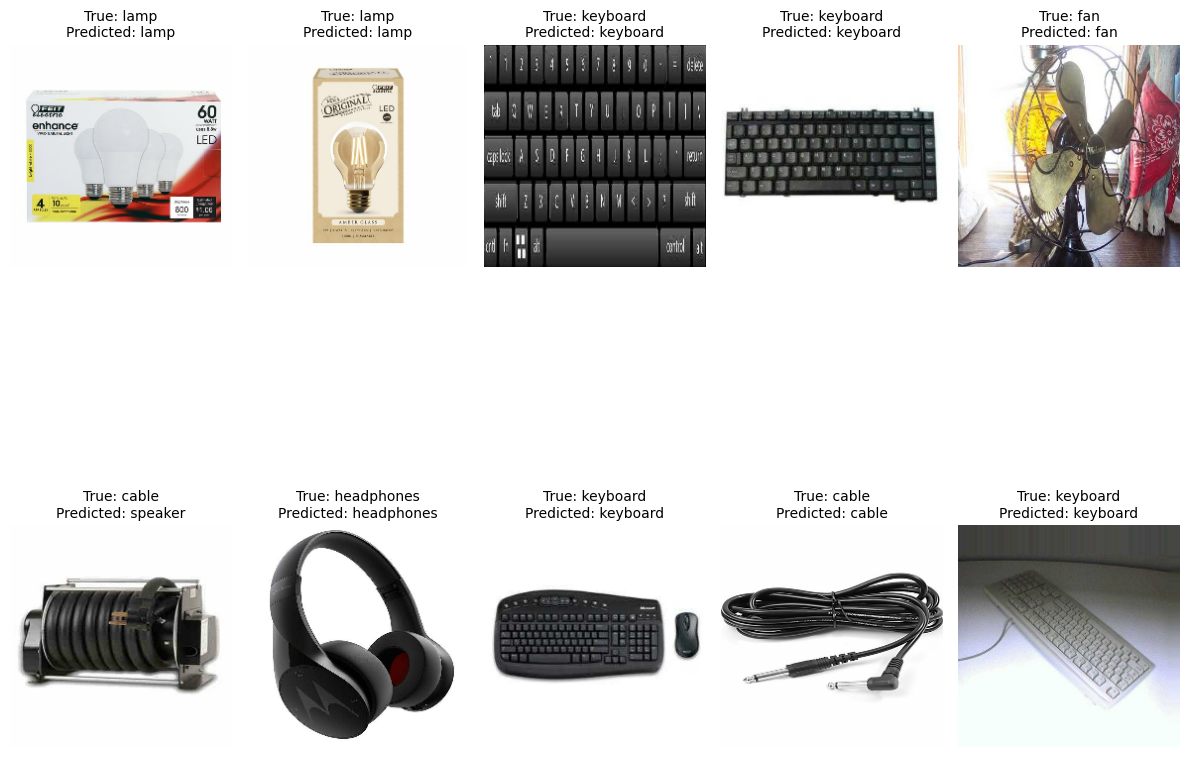

True Predict Count: 9
False Predict Count: 1


In [15]:
# test the model with random images from test dataset
import random

image_batch_test, label_batch_test = next(iter(test_dataset))

image_batch_test, label_batch_test = image_batch_test.numpy(), label_batch_test.numpy()

predicted_batch = model.predict(image_batch_test)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = [np.array(class_names)[i] for i in predicted_ids]

# Map numeric labels to class names
class_names = ['battery', 'cable', 'fan', 'headphones', 'keyboard', 'lamp', 'laptop', 'monitor', 'mouse', 'smartphone', 'speaker', 'television']
true_labels = [class_names[label] for label in label_batch_test]

# Select 10 random images
num_images = 10
random_indices = random.sample(range(len(predicted_class_names)), num_images)
random_images = image_batch_test[random_indices]
random_true_labels = [true_labels[i] for i in random_indices]
random_predicted_labels = [predicted_class_names[i] for i in random_indices]

# Plot the random images with true and predicted labels
plt.figure(figsize=(12, 12))
true_predict = 0
false_predict = 0
for i in range(num_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(random_images[i].astype('uint8'))
    plt.axis('off')
    plt.title(f'True: {random_true_labels[i]}\nPredicted: {random_predicted_labels[i]}', fontsize=10)
    if random_true_labels[i] == random_predicted_labels[i]:
        true_predict += 1
    else:
        false_predict += 1
plt.tight_layout()
plt.show()

print(f'True Predict Count: {true_predict}')
print(f'False Predict Count: {false_predict}')


In [16]:
# unfreeze base_model layer for fine tuning
for layer in model.layers:
  layer.trainable = True

In [17]:
# compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

In [19]:
# train the fine tuning model
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset)

Epoch 1/10
51/51 [==============================] - 106s 1s/step - loss: 0.4711 - accuracy: 0.8662 - val_loss: 0.3041 - val_accuracy: 0.8830
Epoch 2/10
51/51 [==============================] - 52s 968ms/step - loss: 0.3082 - accuracy: 0.8936 - val_loss: 0.2550 - val_accuracy: 0.9136
Epoch 3/10
51/51 [==============================] - 50s 947ms/step - loss: 0.2776 - accuracy: 0.9026 - val_loss: 0.2181 - val_accuracy: 0.9331
Epoch 4/10
51/51 [==============================] - 49s 922ms/step - loss: 0.2398 - accuracy: 0.9210 - val_loss: 0.2355 - val_accuracy: 0.9276
Epoch 5/10
51/51 [==============================] - 51s 929ms/step - loss: 0.2068 - accuracy: 0.9283 - val_loss: 0.2268 - val_accuracy: 0.9359
Epoch 6/10
51/51 [==============================] - 50s 932ms/step - loss: 0.1776 - accuracy: 0.9336 - val_loss: 0.2203 - val_accuracy: 0.9387
Epoch 7/10
51/51 [==============================] - 50s 926ms/step - loss: 0.1647 - accuracy: 0.9398 - val_loss: 0.2314 - val_accuracy: 0.9359
E

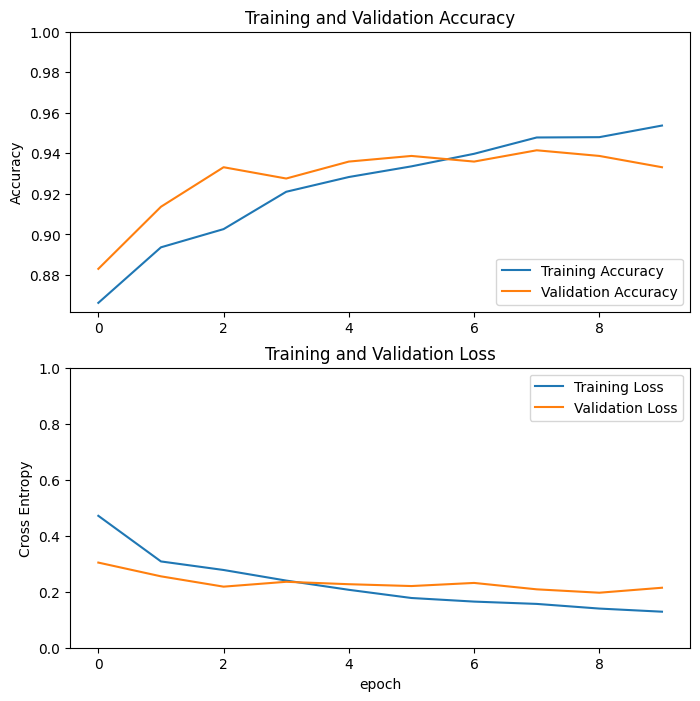

In [20]:
# fine tuning model train monitoring
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [21]:
# evaluate the fine tuning model
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

12/12 [==============================] - 1s 71ms/step - loss: 0.2203 - accuracy: 0.9222
Test accuracy : 0.9222221970558167


1/1 [==============================] - 0s 49ms/step


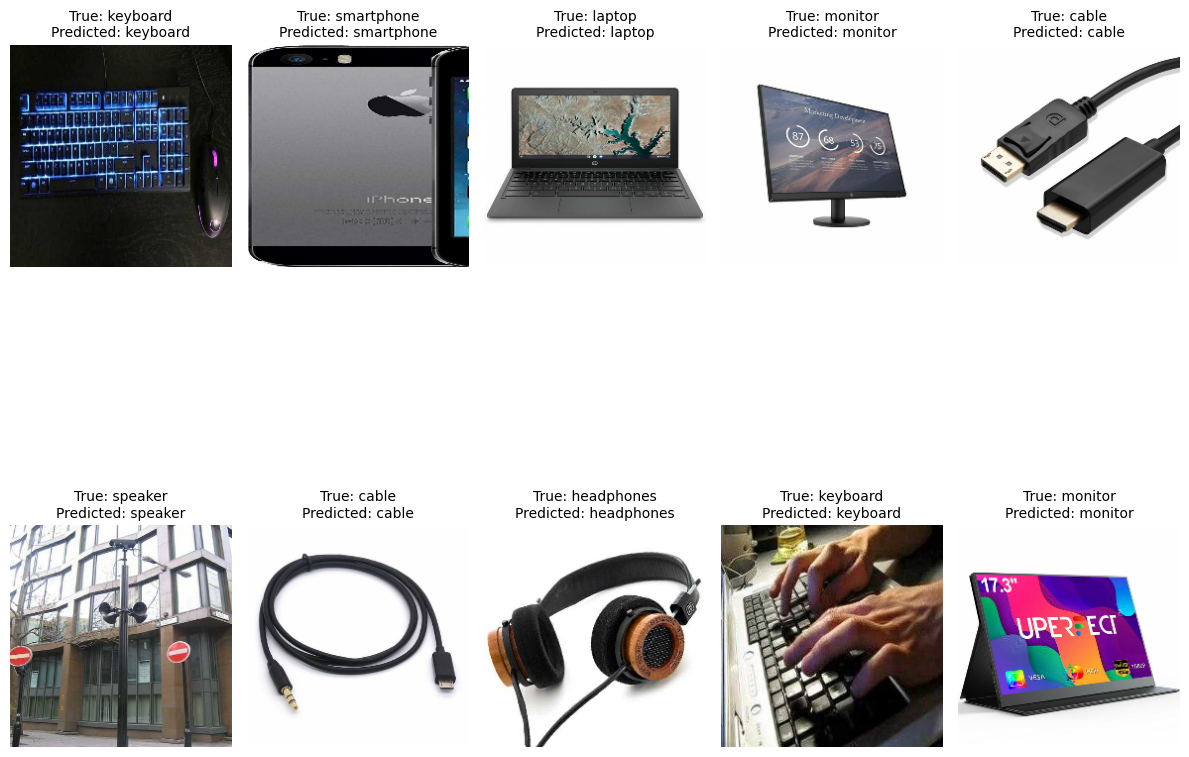

True Predict Count: 10
False Predict Count: 0


In [36]:
# test the model with random images from test dataset
import random

image_batch_test, label_batch_test = next(iter(test_dataset))

image_batch_test, label_batch_test = image_batch_test.numpy(), label_batch_test.numpy()

predicted_batch = model.predict(image_batch_test)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = [np.array(class_names)[i] for i in predicted_ids]

# Map numeric labels to class names
true_labels = [class_names[label] for label in label_batch_test]

# Select 10 random images
num_images = 10
random_indices = random.sample(range(len(predicted_class_names)), num_images)
random_images = image_batch_test[random_indices]
random_true_labels = [true_labels[i] for i in random_indices]
random_predicted_labels = [predicted_class_names[i] for i in random_indices]

# Plot the random images with true and predicted labels
plt.figure(figsize=(12, 12))
true_predict = 0
false_predict = 0
for i in range(num_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(random_images[i].astype('uint8'))
    plt.axis('off')
    plt.title(f'True: {random_true_labels[i]}\nPredicted: {random_predicted_labels[i]}', fontsize=10)
    if random_true_labels[i] == random_predicted_labels[i]:
        true_predict += 1
    else:
        false_predict += 1
plt.tight_layout()
plt.show()

print(f'True Predict Count: {true_predict}')
print(f'False Predict Count: {false_predict}')


In [ ]:
# save model
model.save('ecotronik.h5')

In [ ]:
#Define saved model path
saved_model_path = "/content/drive/Shareddrives/Capstone/saved_model"
tf.saved_model.save(model, saved_model_path)

#Convert the model
converted_model = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
converted_model.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converted_model.convert()

#Save the model
os.makedirs('/content/drive/Shareddrives/Capstone/model_tflite')
with open('/content/drive/Shareddrives/Capstone/model_tflite/tflite_model.tflite', 'wb') as file:
  file.write(tflite_model)